In [86]:
import os
import numpy as np
import random
import copy

import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau

from FeatureAcquisition import FeatureAcquisition
from Predictor import Predictor
from Generators import GaussianSampler

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from PartialVAE import PartialVAE

# Predefined functions

In [13]:
# 하나의 샘플에서 k개가 관측되었다고 가정
# k개의 관측을 임의로 배정

def sample_mask_uniform_K_per_sample(bs, d, min_K, max_K): # batch size, feature 개수, 최소 관측 샘플 수, 최대 관측 샘플 수
    m = np.zeros((bs, d), dtype=np.float32)
    Ks = np.random.randint(min_K, max_K+1, size=(bs,))
    for i, K in enumerate(Ks): # Ks의 index와 해당 index의 값
        idx = np.random.choice(d, size=K, replace=False)
        m[i, idx] = 1.0
    return m

In [14]:
def set_seed(numpy_seed, random_seed, torch_seed_cpu, torch_seed_cuda):
    random.seed(random_seed)
    os.environ["PYTHONHASHSEED"] = str(random_seed)

    np.random.seed(numpy_seed)
    torch.manual_seed(torch_seed_cpu)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(torch_seed_cuda)
        torch.cuda.manual_seed_all(torch_seed_cuda)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [ ]:
def train_predictor(
    predictor,
    train_loader,
    X_val,
    y_val,
    D,
    epochs,
    optimizer,
    criterion,
    lr_factor=0.2,
    cooldown=0,
    min_lr=1e-7,
    scheduler_patience=5
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    predictor.to(device)
    X_val, y_val = X_val.to(device), y_val.to(device)

    scheduler = ReduceLROnPlateau(
        optimizer,
        mode="max",
        factor=lr_factor,
        patience=scheduler_patience,
        cooldown=cooldown,
        min_lr=min_lr,
    )

    best_acc = 0.0
    best_state = None

    for epoch in range(epochs):
        # Train 
        predictor.train()
        total_loss = 0.0
        total_train_samples = 0

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)

            m_np = sample_mask_uniform_K_per_sample(
                bs=xb.size(0),
                d=D,
                min_K=1,
                max_K=D
            )
            mb = torch.tensor(m_np, dtype=torch.float32, device=device)

            logits = predictor(xb, mb)
            loss = criterion(logits, yb)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * xb.size(0)
            total_train_samples += xb.size(0)

        avg_train_loss = total_loss / total_train_samples

        # Validation 
        predictor.eval()
        with torch.no_grad():
            m_np = sample_mask_uniform_K_per_sample(
                bs=X_val.size(0),
                d=D,
                min_K=1,
                max_K=D
            )
            mv = torch.tensor(m_np, dtype=torch.float32, device=device)

            logits_val = predictor(X_val, mv)
            val_loss = criterion(logits_val, y_val).item()

            preds = logits_val.argmax(dim=-1)
            acc = (preds == y_val).float().mean().item()

        # Scheduler update
        scheduler.step(acc)

        # 로그 출력
        current_lr = optimizer.param_groups[0]["lr"]
        print(
            f"Epoch {epoch+1}/{epochs} | "
            f"train_loss={avg_train_loss:.4f} | "
            f"val_loss={val_loss:.4f} | val_acc={acc:.4f} | "
            f"lr={current_lr:.6f}"
        )

        # Best model 저장
        if acc > best_acc:
            best_acc = acc
            best_state = copy.deepcopy(predictor.state_dict())

    # 모든 epoch 후 best 모델 복원
    if best_state is not None:
        predictor.load_state_dict(best_state)

    print(f"Best validation accuracy = {best_acc:.4f}")

In [30]:
def train_generator(
    generator,
    train_loader,
    X_val,
    D, # feature 개수
    epochs,
    optimizer,
    obs_sigma=0.2,
    lr_factor=0.2,
    cooldown=0,
    min_lr=1e-7,
    scheduler_patience=5
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    generator.to(device)
    X_val = X_val.to(device)

    scheduler = ReduceLROnPlateau(
        optimizer,
        mode="min", # loss 기준이기 때문 
        factor=lr_factor,
        patience=scheduler_patience,
        cooldown=cooldown,
        min_lr=min_lr,
    )

    best_val_loss = float("inf")
    best_state = None

    for ep in range(epochs):
        # Train
        generator.train()
        total_loss, total_kl, total_nll = 0.0, 0.0, 0.0
        count = 0

        for xb, _ in train_loader:
            xb = xb.to(device).float()
            bs = xb.size(0)

            m_np = sample_mask_uniform_K_per_sample(
                bs=bs,
                d=D,
                min_K=1,
                max_K=D,
            )
            mb = torch.tensor(m_np, dtype=torch.float32, device=device)

            loss, logs = generator.loss_func(
                xb,
                mb,
                obs_sigma=obs_sigma,
                n_samples=1,
            )

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * bs
            total_kl   += logs["KL"].item() * bs
            total_nll  += logs["NLL_X"].item() * bs
            count      += bs

        train_loss = total_loss / count
        train_kl   = total_kl / count
        train_nll  = total_nll / count

        # Validation
        generator.eval()
        with torch.no_grad():
            bs_val = X_val.size(0)
            m_np = sample_mask_uniform_K_per_sample(
                bs=bs_val,
                d=D,
                min_K=1,
                max_K=D,
            )
            mv = torch.tensor(m_np, dtype=torch.float32, device=device)

            val_loss_tensor, val_logs = generator.loss_func(
                X_val,
                mv,
                obs_sigma=obs_sigma,
                n_samples=1,
            )

            val_loss = val_loss_tensor.item()
            val_kl   = val_logs["KL"].item()
            val_nll  = val_logs["NLL_X"].item()

        # 스케줄러 업데이트 (val_loss 기준)
        scheduler.step(val_loss)
        current_lr = optimizer.param_groups[0]["lr"]

        print(
            f"[PVAE ep {ep:02d}] "
            f"train_loss={train_loss:.4f}  train_KL={train_kl:.4f}  train_NLL_X={train_nll:.4f} | "
            f"val_loss={val_loss:.4f}  val_KL={val_kl:.4f}  val_NLL_X={val_nll:.4f} | "
            f"lr={current_lr:.6f}"
        )

        # best model 저장 (val_loss 최소 기준)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state = copy.deepcopy(generator.state_dict())

    # 가장 좋은 val_loss 기준으로 weight 복원
    if best_state is not None:
        generator.load_state_dict(best_state)

    print(f"Best val_loss = {best_val_loss:.4f}")

In [17]:
def run_feature_acquisition(
    predictor,
    generator,
    X_test,
    y_test,
    x_np,
    m_np,
    D,
    num_samples=10,
    alpha=1.0,
    gamma=0.5
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    predictor.eval()

    accs = []

    for t in range(1, D+1):
        FA = FeatureAcquisition(
            x=x_np,
            m=m_np,
            generative_model=generator,
            num_samples=num_samples,
            predictor=predictor,
            alpha=alpha,
            gamma=gamma
        )

        # mask 업데이트
        m_np, _ = FA.acquire()

        # 모델 inference
        with torch.no_grad():
            xv = X_test.to(device)
            mv = torch.tensor(m_np, dtype=torch.float32, device=device)
            logits = predictor(xv, mv)
            y_pred = logits.argmax(dim=-1).cpu().numpy()

        y_true = y_test.cpu().numpy()

        acc_t = accuracy_score(y_true, y_pred)
        accs.append(acc_t)

        print(f"Step {t}/{D} | Acc: {acc_t:.4f}")

    return accs

# CUBE

In [18]:
ROOT_DIR = os.getcwd()
DATA_DIR = os.path.join(ROOT_DIR, "data", "cube")

X_train = torch.load(f"{DATA_DIR}/X_train_cdf.pt").float()
y_train = torch.load(f"{DATA_DIR}/y_train.pt").long()

X_val   = torch.load(f"{DATA_DIR}/X_val_cdf.pt").float()
y_val   = torch.load(f"{DATA_DIR}/y_val.pt").long()

X_test = torch.load(f"{DATA_DIR}/X_test_cdf.pt").float()
y_test = torch.load(f"{DATA_DIR}/y_test.pt").long()

## Partial VAE

In [ ]:
batch_size = 256
epochs = 100
lr = 1e-3
weight_decay = 1e-4
D = 20  # feature 개수 고정

predictor = Predictor(feature_dim=20, num_classes=8, hidden_dim=128)
optimizer = AdamW(predictor.parameters(), lr=lr, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

train_ds = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=False)

train_predictor(
    predictor=predictor,
    train_loader=train_loader,
    X_val=X_val,
    y_val=y_val,
    D=D,
    epochs=epochs,
    optimizer=optimizer,
    criterion=criterion
)

Epoch 1/100 | train_loss=1.3629 | val_loss=0.9931 | val_acc=0.6352 | lr=0.001000
Epoch 2/100 | train_loss=1.0505 | val_loss=0.9101 | val_acc=0.6614 | lr=0.001000
Epoch 3/100 | train_loss=1.0001 | val_loss=0.8844 | val_acc=0.6640 | lr=0.001000
Epoch 4/100 | train_loss=0.9750 | val_loss=0.8625 | val_acc=0.6653 | lr=0.001000
Epoch 5/100 | train_loss=0.9536 | val_loss=0.8484 | val_acc=0.6696 | lr=0.001000
Epoch 6/100 | train_loss=0.9272 | val_loss=0.8240 | val_acc=0.6776 | lr=0.001000
Epoch 7/100 | train_loss=0.9032 | val_loss=0.8107 | val_acc=0.6763 | lr=0.001000
Epoch 8/100 | train_loss=0.8798 | val_loss=0.7840 | val_acc=0.6849 | lr=0.001000
Epoch 9/100 | train_loss=0.8662 | val_loss=0.7770 | val_acc=0.6834 | lr=0.001000
Epoch 10/100 | train_loss=0.8589 | val_loss=0.7705 | val_acc=0.6829 | lr=0.001000
Epoch 11/100 | train_loss=0.8416 | val_loss=0.7608 | val_acc=0.6836 | lr=0.001000
Epoch 12/100 | train_loss=0.8273 | val_loss=0.7450 | val_acc=0.6939 | lr=0.001000
Epoch 13/100 | train_loss

In [ ]:
batch_size = 256
epochs = 100
lr = 1e-3
weight_decay = 1e-4

pvae = PartialVAE(
    input_type="continuous",
    num_con_features=20,
    num_cat_features=0,
    hidden_dim_con=30,
    most_categories=max(1, 0),   # 내부 차원 계산을 위해 최소 1
    c_dim=16,
    hid_enc=100,
    hid_dec=100,
    latent_dim=30
)
optimizer = AdamW(pvae.parameters(), lr=lr, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

train_generator(
    generator=pvae,
    train_loader=train_loader,
    X_val=X_val,
    D=D, # feature 개수
    epochs=epochs,
    optimizer=optimizer,
    obs_sigma=0.2,
    lr_factor=0.2,
    cooldown=0,
    min_lr=1e-7,
    scheduler_patience=5
)

[PVAE ep 00] train_loss=13.0065  train_KL=0.9778  train_NLL_X=12.0287 | val_loss=11.9748  val_KL=1.2237  val_NLL_X=10.7511 | lr=0.001000
[PVAE ep 01] train_loss=11.6438  train_KL=1.5089  train_NLL_X=10.1349 | val_loss=11.5490  val_KL=1.7024  val_NLL_X=9.8465 | lr=0.001000
[PVAE ep 02] train_loss=11.3304  train_KL=1.8065  train_NLL_X=9.5239 | val_loss=11.3207  val_KL=1.9638  val_NLL_X=9.3568 | lr=0.001000
[PVAE ep 03] train_loss=11.1358  train_KL=2.0393  train_NLL_X=9.0965 | val_loss=11.1068  val_KL=2.1557  val_NLL_X=8.9511 | lr=0.001000
[PVAE ep 04] train_loss=10.9877  train_KL=2.1897  train_NLL_X=8.7980 | val_loss=10.9744  val_KL=2.2001  val_NLL_X=8.7743 | lr=0.001000
[PVAE ep 05] train_loss=10.9236  train_KL=2.2487  train_NLL_X=8.6749 | val_loss=10.9707  val_KL=2.3134  val_NLL_X=8.6574 | lr=0.001000
[PVAE ep 06] train_loss=10.8872  train_KL=2.3109  train_NLL_X=8.5763 | val_loss=10.8843  val_KL=2.4310  val_NLL_X=8.4533 | lr=0.001000
[PVAE ep 07] train_loss=10.8156  train_KL=2.3848  tr

In [108]:
predictor.eval()
N = X_test.size(0)
D = X_test.size(1)
x_np = X_test.cpu().numpy()
m_np = np.zeros((N, D), dtype=np.float32)

result = []

accs = run_feature_acquisition(
    predictor=predictor,
    generator=pvae,
    X_test=X_test,
    y_test=y_test,
    x_np=x_np,
    m_np=m_np,
    D=D,
    num_samples=10,
    alpha=1,
    gamma=0.2
)

result.append(accs)

Step 1/20 | Acc: 0.3225
Step 2/20 | Acc: 0.5435
Step 3/20 | Acc: 0.7433
Step 4/20 | Acc: 0.8580
Step 5/20 | Acc: 0.9141
Step 6/20 | Acc: 0.9440
Step 7/20 | Acc: 0.9560
Step 8/20 | Acc: 0.9600
Step 9/20 | Acc: 0.9613
Step 10/20 | Acc: 0.9617
Step 11/20 | Acc: 0.9614
Step 12/20 | Acc: 0.9617
Step 13/20 | Acc: 0.9616
Step 14/20 | Acc: 0.9613
Step 15/20 | Acc: 0.9612
Step 16/20 | Acc: 0.9614
Step 17/20 | Acc: 0.9614
Step 18/20 | Acc: 0.9617
Step 19/20 | Acc: 0.9616
Step 20/20 | Acc: 0.9619


전체 평균: 0.8889801
표준편차: 0.0
acquisition 별 평균): [0.3225 0.5435 0.7433 0.858  0.9141 0.944  0.956  0.96   0.9613 0.9617
 0.9614 0.9617 0.9616 0.9613 0.9612 0.9614 0.9614 0.9617 0.9616 0.9619]


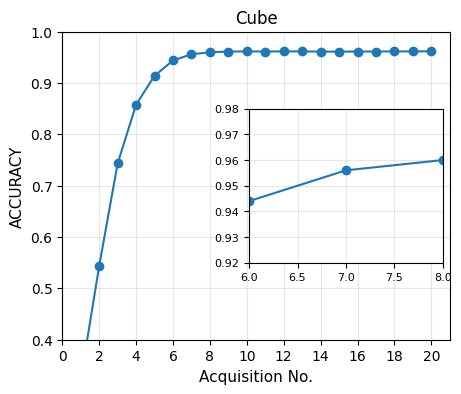

Mean ACC over all acquisitions = 0.8890


In [109]:
result = np.array(result, dtype=np.float32)

num_runs, D = result.shape
row_means = result.mean(axis=1)
overall_mean = row_means.mean()

std = row_means.std()

col_means = result.mean(axis=0)

print("전체 평균:", overall_mean)
print("표준편차:", std)
print("acquisition 별 평균):", col_means)

# 시각화
xs = np.arange(1, D + 1)

plt.figure(figsize=(5, 4))
plt.plot(xs, col_means, marker='o')
plt.xlabel('Acquisition No.', fontsize=11)
plt.ylabel('ACCURACY', fontsize=11)
plt.title('Cube', fontsize=12)
plt.xticks(np.arange(0, D+1, 2))
plt.xlim(0, D + 1)
plt.ylim(0.4, 1.0)
plt.grid(True, alpha=0.3)

# 확대 영역
ax = plt.gca()
axins = inset_axes(ax, width="50%", height="50%", loc='center right')

axins.plot(xs, col_means, marker='o')
axins.set_xlim(6, 8)
axins.set_ylim(0.92, 0.98)
axins.grid(True, alpha=0.3)
axins.tick_params(labelsize=8)

plt.show()

mean_acc = np.nanmean(col_means)
print(f"Mean ACC over all acquisitions = {mean_acc:.4f}")

## ACFlow

# Bank Marketing

## Partial VAE

## ACFlow

# California Housing

In [112]:
ROOT_DIR = os.getcwd()
DATA_DIR = os.path.join(ROOT_DIR, "data", "california_housing")

X_train = torch.load(f"{DATA_DIR}/X_train_cdf.pt").float()
y_train = torch.load(f"{DATA_DIR}/y_train.pt").long()

X_val   = torch.load(f"{DATA_DIR}/X_val_cdf.pt").float()
y_val   = torch.load(f"{DATA_DIR}/y_val.pt").long()

X_test = torch.load(f"{DATA_DIR}/X_test_cdf.pt").float()
y_test = torch.load(f"{DATA_DIR}/y_test.pt").long()

In [120]:
batch_size = 256
epochs = 100
lr = 1e-3
weight_decay = 1e-4
D = 8  # feature 개수 고정

predictor = Predictor(feature_dim=8, num_classes=4, hidden_dim=128)
optimizer = AdamW(predictor.parameters(), lr=lr, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

train_ds = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=False)

train_predictor(
    predictor=predictor,
    train_loader=train_loader,
    X_val=X_val,
    y_val=y_val,
    D=D,
    epochs=epochs,
    optimizer=optimizer,
    criterion=criterion
)

Epoch 1/100 | train_loss=1.3266 | val_loss=1.1922 | val_acc=0.4438 | lr=0.001000
Epoch 2/100 | train_loss=1.2140 | val_loss=1.1418 | val_acc=0.4646 | lr=0.001000
Epoch 3/100 | train_loss=1.1870 | val_loss=1.1550 | val_acc=0.4617 | lr=0.001000
Epoch 4/100 | train_loss=1.1667 | val_loss=1.1349 | val_acc=0.4656 | lr=0.001000
Epoch 5/100 | train_loss=1.1669 | val_loss=1.1320 | val_acc=0.4772 | lr=0.001000
Epoch 6/100 | train_loss=1.1402 | val_loss=1.1179 | val_acc=0.4879 | lr=0.001000
Epoch 7/100 | train_loss=1.1413 | val_loss=1.1075 | val_acc=0.4806 | lr=0.001000
Epoch 8/100 | train_loss=1.1400 | val_loss=1.1215 | val_acc=0.4845 | lr=0.001000
Epoch 9/100 | train_loss=1.1365 | val_loss=1.1227 | val_acc=0.4680 | lr=0.001000
Epoch 10/100 | train_loss=1.1307 | val_loss=1.0925 | val_acc=0.4952 | lr=0.001000
Epoch 11/100 | train_loss=1.1282 | val_loss=1.1018 | val_acc=0.4985 | lr=0.001000
Epoch 12/100 | train_loss=1.1288 | val_loss=1.0899 | val_acc=0.4855 | lr=0.001000
Epoch 13/100 | train_loss

In [124]:
batch_size = 256
epochs = 100
lr = 1e-3
weight_decay = 1e-4

pvae = PartialVAE(
    input_type="continuous",
    num_con_features=8,
    num_cat_features=0,
    hidden_dim_con=30,
    most_categories=max(1, 0),   # 내부 차원 계산을 위해 최소 1
    c_dim=16,
    hid_enc=100,
    hid_dec=100,
    latent_dim=30
)
optimizer = AdamW(pvae.parameters(), lr=lr, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

train_generator(
    generator=pvae,
    train_loader=train_loader,
    X_val=X_val,
    D=D, # feature 개수
    epochs=epochs,
    optimizer=optimizer,
    obs_sigma=0.2,
    lr_factor=0.2,
    cooldown=0,
    min_lr=1e-7,
    scheduler_patience=5
)

[PVAE ep 00] train_loss=11.7731  train_KL=1.6943  train_NLL_X=10.0788 | val_loss=9.4672  val_KL=1.7616  val_NLL_X=7.7055 | lr=0.001000
[PVAE ep 01] train_loss=8.5300  train_KL=1.9581  train_NLL_X=6.5719 | val_loss=7.9932  val_KL=2.2465  val_NLL_X=5.7467 | lr=0.001000
[PVAE ep 02] train_loss=7.7438  train_KL=2.2561  train_NLL_X=5.4877 | val_loss=7.6019  val_KL=2.3280  val_NLL_X=5.2739 | lr=0.001000
[PVAE ep 03] train_loss=7.3899  train_KL=2.4208  train_NLL_X=4.9691 | val_loss=7.3480  val_KL=2.4866  val_NLL_X=4.8614 | lr=0.001000
[PVAE ep 04] train_loss=7.0977  train_KL=2.4944  train_NLL_X=4.6033 | val_loss=6.9477  val_KL=2.5716  val_NLL_X=4.3761 | lr=0.001000
[PVAE ep 05] train_loss=6.8760  train_KL=2.5447  train_NLL_X=4.3313 | val_loss=6.8460  val_KL=2.6613  val_NLL_X=4.1847 | lr=0.001000
[PVAE ep 06] train_loss=6.6861  train_KL=2.6079  train_NLL_X=4.0782 | val_loss=6.5659  val_KL=2.6277  val_NLL_X=3.9382 | lr=0.001000
[PVAE ep 07] train_loss=6.5222  train_KL=2.6392  train_NLL_X=3.8831

In [129]:
predictor.eval()
N = X_test.size(0)
D = X_test.size(1)
x_np = X_test.cpu().numpy()
m_np = np.zeros((N, D), dtype=np.float32)

result = []

accs = run_feature_acquisition(
    predictor=predictor,
    generator=pvae,
    X_test=X_test,
    y_test=y_test,
    x_np=x_np,
    m_np=m_np,
    D=D,
    num_samples=10,
    alpha=1,
    gamma=0.2
)

result.append(accs)

Step 1/8 | Acc: 0.4821
Step 2/8 | Acc: 0.5339
Step 3/8 | Acc: 0.5819
Step 4/8 | Acc: 0.6148
Step 5/8 | Acc: 0.6192
Step 6/8 | Acc: 0.6289
Step 7/8 | Acc: 0.6468
Step 8/8 | Acc: 0.6526


전체 평균: 0.5950218
표준편차: 0.0
acquisition 별 평균): [0.48207363 0.53391474 0.58187985 0.6148256  0.61918604 0.628876
 0.6468023  0.65261626]


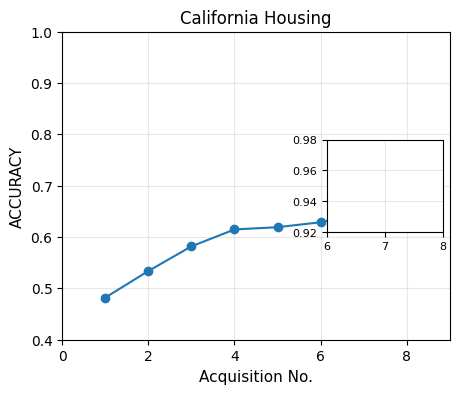

Mean ACC over all acquisitions = 0.5950


In [132]:
result = np.array(result, dtype=np.float32)

num_runs, D = result.shape
row_means = result.mean(axis=1)
overall_mean = row_means.mean()

std = row_means.std()

col_means = result.mean(axis=0)

print("전체 평균:", overall_mean)
print("표준편차:", std)
print("acquisition 별 평균):", col_means)

# 시각화
xs = np.arange(1, D + 1)

plt.figure(figsize=(5, 4))
plt.plot(xs, col_means, marker='o')
plt.xlabel('Acquisition No.', fontsize=11)
plt.ylabel('ACCURACY', fontsize=11)
plt.title('California Housing', fontsize=12)
plt.xticks(np.arange(0, D+1, 2))
plt.xlim(0, D + 1)
plt.ylim(0.4, 1.0)
plt.grid(True, alpha=0.3)

# 확대 영역
ax = plt.gca()
axins = inset_axes(ax, width="30%", height="30%", loc='center right')

axins.plot(xs, col_means, marker='o')
axins.set_xlim(6, 8)
axins.set_ylim(0.92, 0.98)
axins.grid(True, alpha=0.3)
axins.tick_params(labelsize=8)

plt.show()

mean_acc = np.nanmean(col_means)
print(f"Mean ACC over all acquisitions = {mean_acc:.4f}")

## Partial VAE

## ACFlow

# MiniBooNE

## Partial VAE

## ACFlow

# MNIST

## Partial VAE

## ACFlow

# Fashion MNIST

## Partial VAE

## ACFlow

# METABRIC

## Partial VAE

## ACFlow

# TCGA

## Partial VAE

## ACFlow